# Imports

In [6]:
import requests
from typing import Optional
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log10
from time import sleep
import numpy as np
import os

from silly_smells.pubchem_retriever import fetch_pubchem_data
from silly_smells.fingerprint_manipulations import base_64_to_np_array

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Explore Dataset

## Opening

In [7]:
data_path='../data_resources/TrainSet.txt'

In [8]:
temp=pd.read_csv(data_path,sep='\t')

# Inspect Dataset

In [9]:
temp

,Compound Identifier,Odor,Replicate,Intensity,Dilution,subject #,INTENSITY/STRENGTH,VALENCE/PLEASANTNESS,BAKERY,SWEET,...,ACID,WARM,MUSKY,SWEATY,AMMONIA/URINOUS,DECAYED,WOOD,GRASS,FLOWER,CHEMICAL
0,126,4-Hydroxybenzaldehyde,NaN,low,"1/1,000",1,7,62.0,0.0,0.0,...,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0
1,126,4-Hydroxybenzaldehyde,NaN,high,1/10,1,37,60.0,0.0,72.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,126,4-Hydroxybenzaldehyde,NaN,low,"1/1,000",2,55,89.0,0.0,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,126,4-Hydroxybenzaldehyde,NaN,high,1/10,2,64,71.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
4,126,4-Hydroxybenzaldehyde,NaN,low,"1/1,000",3,89,68.0,0.0,62.0,...,0.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35079,6999977,Butyl (S)-(-)-lactate,NaN,high,"1/1,000",47,42,77.0,56.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35080,6999977,Butyl (S)-(-)-lactate,NaN,low,"1/100,000",48,0,72.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35081,6999977,Butyl (S)-(-)-lactate,NaN,high,"1/1,000",48,22,96.0,0.0,58.0,...,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0
35082,6999977,Butyl (S)-(-)-lactate,NaN,low,"1/100,000",49,72,9.0,0.0,0.0,...,0.0,0.0,19.0,9.0,0.0,2.0,0.0,0.0,0.0,3.0


In [10]:
temp.dtypes

Compound Identifier       int64
Odor                     object
Replicate                object
Intensity                object
Dilution                 object
subject #                 int64
INTENSITY/STRENGTH        int64
VALENCE/PLEASANTNESS    float64
BAKERY                  float64
SWEET                   float64
FRUIT                   float64
FISH                    float64
GARLIC                  float64
SPICES                  float64
COLD                    float64
SOUR                    float64
BURNT                   float64
ACID                    float64
WARM                    float64
MUSKY                   float64
SWEATY                  float64
AMMONIA/URINOUS         float64
DECAYED                 float64
WOOD                    float64
GRASS                   float64
FLOWER                  float64
CHEMICAL                float64
dtype: object

Looking at the various columns, most seem like numerical smell magnitudes
I recognize CID, "odor" seems to be "IUPAC name".
Attacking in a fairly random order...

## Replicate Removal

Without technically analyzing, we will assume replicate means (technical replicate) and ignore those 

In [11]:
temp.Replicate.value_counts()

Replicate
replicate     1960
Name: count, dtype: int64

In [12]:
# remove rows where the value of replicate is not nan
temp=temp.loc[pd.isnull(temp.Replicate)].copy(deep=True)
# remove the replicate column
temp=temp.drop('Replicate',axis='columns')

## Missing Values

In [13]:
# probe for missing values in other columns
temp.isna().sum()

Compound Identifier        0
Odor                       0
Intensity                  0
Dilution                   0
subject #                  0
INTENSITY/STRENGTH         0
VALENCE/PLEASANTNESS    8617
BAKERY                  8617
SWEET                   8617
FRUIT                   8617
FISH                    8617
GARLIC                  8617
SPICES                  8617
COLD                    8617
SOUR                    8617
BURNT                   8617
ACID                    8617
WARM                    8617
MUSKY                   8617
SWEATY                  8617
AMMONIA/URINOUS         8617
DECAYED                 8617
WOOD                    8617
GRASS                   8617
FLOWER                  8617
CHEMICAL                8617
dtype: int64

Same number of missing values in each semll magnitude column
Probably mean that some rows have no "y-value"
Looking at those rows where the missing

In [14]:
temp.loc[temp['VALENCE/PLEASANTNESS'].isna()]

,Compound Identifier,Odor,Intensity,Dilution,subject #,INTENSITY/STRENGTH,VALENCE/PLEASANTNESS,BAKERY,SWEET,FRUIT,...,ACID,WARM,MUSKY,SWEATY,AMMONIA/URINOUS,DECAYED,WOOD,GRASS,FLOWER,CHEMICAL
5,126,4-Hydroxybenzaldehyde,high,1/10,3,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,126,4-Hydroxybenzaldehyde,low,"1/1,000",5,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,126,4-Hydroxybenzaldehyde,low,"1/1,000",6,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,126,4-Hydroxybenzaldehyde,low,"1/1,000",9,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,126,4-Hydroxybenzaldehyde,low,"1/1,000",11,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35064,6999977,Butyl (S)-(-)-lactate,low,"1/100,000",40,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35066,6999977,Butyl (S)-(-)-lactate,low,"1/100,000",41,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35070,6999977,Butyl (S)-(-)-lactate,low,"1/100,000",43,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35076,6999977,Butyl (S)-(-)-lactate,low,"1/100,000",46,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


we see that intensity is very often "low" -> intuition that dilution is not important (intensity is the "biology-normalized" version of dilution), and so, basically, we make a guess that "the values are nan when the person couldnt smell anything"

In [15]:
# hypothesis confirmation
temp.loc[temp['VALENCE/PLEASANTNESS'].isna()]['Intensity'].value_counts()

Intensity
low      6425
high     2192
Name: count, dtype: int64

In [16]:
temp=temp.loc[~temp['VALENCE/PLEASANTNESS'].isna()]

## A little exploration

In [17]:
temp.iloc[:,6:]

,VALENCE/PLEASANTNESS,BAKERY,SWEET,FRUIT,FISH,GARLIC,SPICES,COLD,SOUR,BURNT,ACID,WARM,MUSKY,SWEATY,AMMONIA/URINOUS,DECAYED,WOOD,GRASS,FLOWER,CHEMICAL
0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0
1,60.0,0.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,89.0,0.0,33.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,71.0,0.0,9.0,2.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
4,68.0,0.0,62.0,0.0,0.0,0.0,35.0,0.0,0.0,0.0,0.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35079,77.0,56.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35080,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35081,96.0,0.0,58.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0
35082,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,19.0,9.0,0.0,2.0,0.0,0.0,0.0,3.0


In [18]:
# take a while but is nice. could randomly sample.
# pd.plotting.scatter_matrix(
#     temp.iloc[:,6:]
# )
# plt.show()

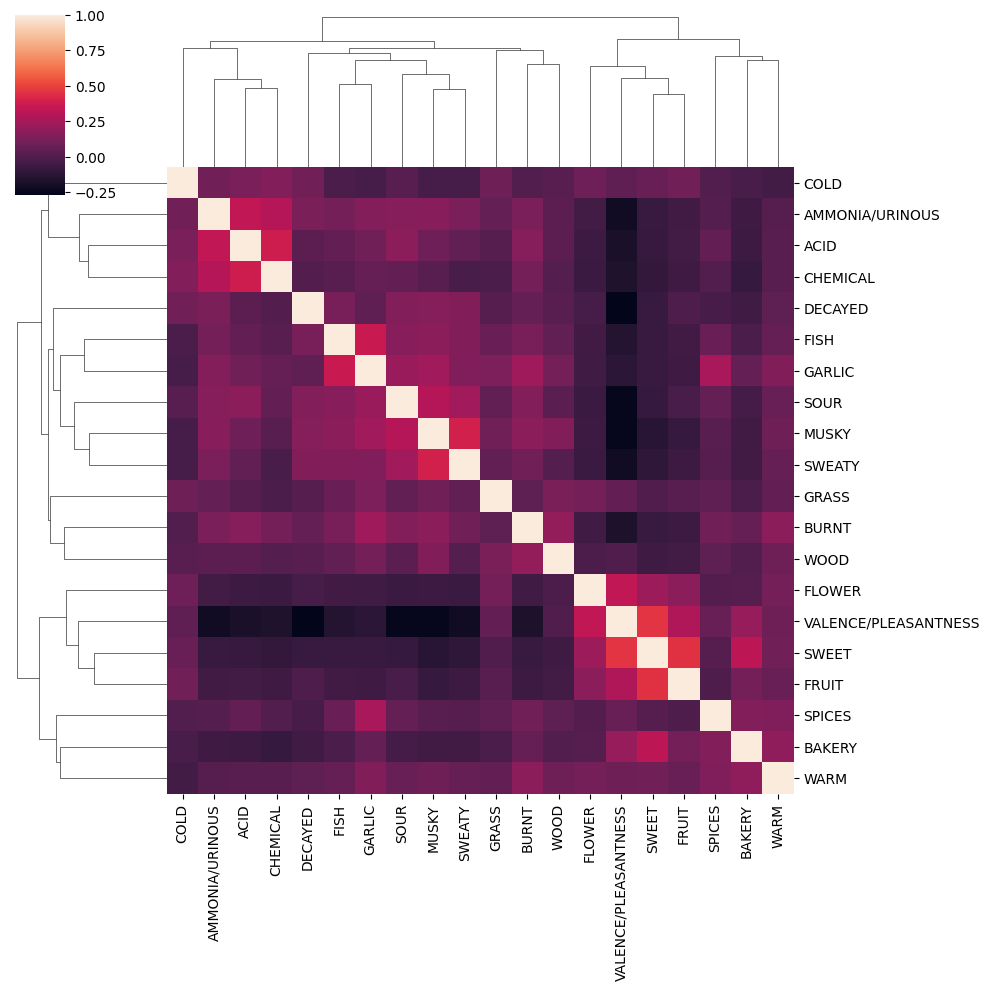

In [19]:
sns.clustermap(temp.iloc[:,6:].corr())

correlations among pleasantness, sweet, etc
ammonia, acid, chemical
what is cold

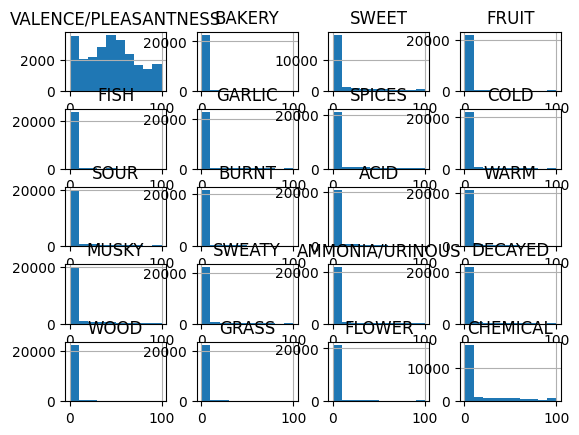

In [20]:
temp.dropna().iloc[:,6:].hist()
plt.show()

Pleasantness seems to be handled differently than other values. Maybe the method was something like: "you MUST give a pleasantness value. Also, if you smell anyt of these vibes, let us know.

Is there true signal in the numeric value (compared to a binary value)? How many of the subjects have professional palettes? Should we transform the signal into a logscale? Is the signal better more like a binary thing (someone smelled something at all, or not)

In [21]:
# Why wouldnt this work?
# temp.dropna().iloc[:,7:].apply(log10).hist()

Final wrangling into usable dataset

Decisions:
- one model for pleasantness
- one model for another chemical. chose 'chemical' because it seems to have the most non-zero feedback
- turn the chemical signal into 0/1 because im not sure that it has meaning
- remove all of the "low intensity" analogs for simplicity
- remove other columns

In [22]:
temp['Intensity'].value_counts()

Intensity
high     14370
low      10137
Name: count, dtype: int64

In [23]:
temp.Intensity.unique()

array(['low ', 'high '], dtype=object)

In [24]:
temp=temp.dropna()
temp=temp.loc[temp['Intensity']=='high '].copy(deep=True)
temp=temp.drop(list(set(temp.columns.unique()).difference({'Compound Identifier','VALENCE/PLEASANTNESS','CHEMICAL'})),axis='columns')
temp=temp.rename({
    'Compound Identifier':'cid',
    'VALENCE/PLEASANTNESS':'pleasantly',
    'CHEMICAL':'chemically'
},axis='columns')

In [25]:
temp.chemically=temp.chemically.apply(lambda x: 1 if x>0 else 0)

the result

In [26]:
temp

,cid,pleasantly,chemically
1,126,60.0,0
3,126,71.0,1
7,126,90.0,0
9,126,58.0,0
11,126,49.0,0
...,...,...,...
35075,6999977,64.0,0
35077,6999977,51.0,1
35079,6999977,77.0,0
35081,6999977,96.0,1


problem: kind of an interesting situation where we will have n rows for each chemical (so the exact same chemical description and ~number of participants answers for otuput)

does it make sense to try to groupby/collapse for each chemical now?

In [27]:
# for chemical,temp_df in temp.groupby('odor'):
#     plt.figure(figsize=(1,1))
#     sns.histplot(temp_df.chemically.tolist())
#     plt.show()

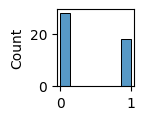

hold 


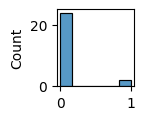

hold 


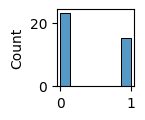

hold 


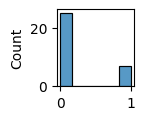

hold 


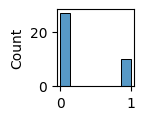

hold 


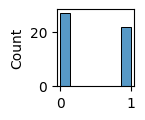

hold 


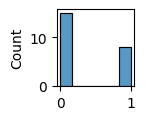

hold 


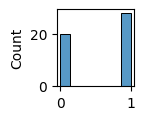

hold 


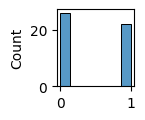

KeyboardInterrupt: Interrupted by user

In [30]:
for chemical,temp_df in temp.groupby('cid'):
    plt.figure(figsize=(1,1))
    sns.histplot(temp_df.chemically.tolist())
    plt.show()
    hold=input('hold')

In [31]:
# opt to make the y the mean
temp=temp.groupby('cid').mean().reset_index()

array([[<Axes: title={'center': 'cid'}>,
        <Axes: title={'center': 'pleasantly'}>],
       [<Axes: title={'center': 'chemically'}>, <Axes: >]], dtype=object)

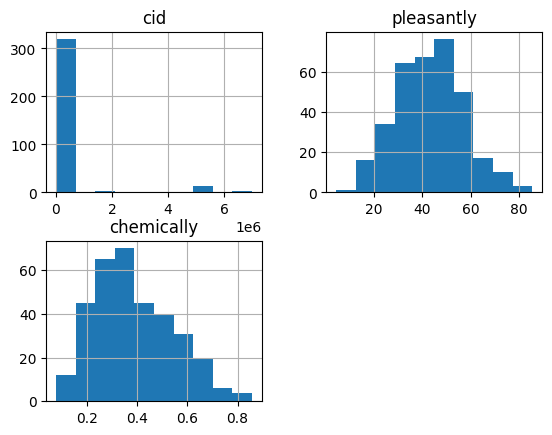

In [32]:
temp.hist()

I'm a little suspicious of our choice to binaryatize first now, but i dont think its gross

In [33]:
# All wrangling steps
temp=pd.read_csv(data_path,sep='\t')
temp=temp.loc[pd.isnull(temp.Replicate)].copy(deep=True)
temp=temp.drop('Replicate',axis='columns')
temp=temp.dropna()
temp=temp.loc[temp['Intensity']=='high '].copy(deep=True)
temp=temp.drop(list(set(temp.columns.unique()).difference({'Compound Identifier','VALENCE/PLEASANTNESS','CHEMICAL'})),axis='columns')
temp=temp.rename({
    'Compound Identifier':'cid',
    'VALENCE/PLEASANTNESS':'pleasantly',
    'CHEMICAL':'chemically'
},axis='columns')
temp.chemically=temp.chemically.apply(lambda x: 1 if x>0 else 0)
temp=temp.groupby('cid').mean().reset_index()
temp=pd.merge(
    left=temp,
    right=pd.read_csv(data_path,sep='\t')[['Compound Identifier','Odor']].drop_duplicates(subset=['Compound Identifier']),
    left_on='cid',
    right_on='Compound Identifier',
    how='inner',
    validate='one_to_one'
).drop('Compound Identifier',axis='columns').rename({'Odor':'odor'},axis='columns')
temp=temp[['cid','odor','pleasantly','chemically']]

In [34]:
temp

,cid,odor,pleasantly,chemically
0,126,4-Hydroxybenzaldehyde,48.956522,0.391304
1,176,acetic acid,48.461538,0.076923
2,177,acetaldehyde,45.315789,0.394737
3,196,Adipic acid,53.218750,0.218750
4,239,beta-Alanine,51.351351,0.270270
...,...,...,...,...
333,5366244,Phytol,27.395833,0.625000
334,5367706,cis-3-Hexenyl benzoate,41.638889,0.333333
335,5368076,Methyl trans-2-nonenoate,50.853659,0.317073
336,6429333,2-Phenyl-2-butenal,36.548387,0.193548


# Train and test a model

## Descriptors

we want to map structure to smell. we need some way to describe compounds. lets use the pubchem fingerprints (organic-chemistry covalent bond and atomicity)

In [35]:
def wrap_pubchem_fetch_for_smells(df:pd.DataFrame,chunk_size=100) -> pd.DataFrame:
    total_records=list()
    for i in range(13):
        these_cids=df.iloc[i*26:i*26+26]['cid'].tolist()
        these_records=fetch_pubchem_data(these_cids,'cid')
        total_records.extend(these_records)
        sleep(0.5)
    return pd.DataFrame.from_records(total_records)


In [36]:
smell_df_descriptors=wrap_pubchem_fetch_for_smells(temp)

In [37]:
smell_df_descriptors= smell_df_descriptors.rename({
    'CID':'cid',
    'SMILES':'smiles',
    'InChIKey':'inchikey',
    'CACTVS_Fingerprint':'fingerprint'
    },
    axis='columns'
)

In [38]:
smell_df=pd.merge(
    left=temp,
    right=smell_df_descriptors,
    on='cid'
)

In [39]:
smell_df.fingerprint=smell_df.fingerprint.apply(base_64_to_np_array)

In [40]:
smell_df_shuffled=smell_df.sample(frac=1).reset_index(drop=True)

In [44]:
smell_df_shuffled

,cid,odor,pleasantly,chemically,smiles,inchikey,fingerprint
0,637796,Isosafrole,58.250000,0.318182,C/C=C/C1=CC2=C(C=C1)OCO2,None,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ..."
1,1183,vanillin,85.553191,0.085106,COC1=C(C=CC(=C1)C=O)O,None,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ..."
2,5365049,cis-3-Hexenyl propionate,65.891304,0.173913,CC/C=C\CCOC(=O)CC,None,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ..."
3,8712,o-Toluenethiol,24.456522,0.217391,CC1=CC=CC=C1S,None,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ..."
4,62374,4-Oxoisophorone,45.930233,0.325581,CC1=CC(=O)CC(C1=O)(C)C,None,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ..."
...,...,...,...,...,...,...,...
333,9025,"1,3-Dimethoxybenzene",50.000000,0.551020,COC1=CC(=CC=C1)OC,None,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ..."
334,2969,decanoic acid,29.166667,0.520833,CCCCCCCCCC(=O)O,None,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ..."
335,32594,2-isobutyl-3-methoxypyrazine,31.571429,0.265306,CC(C)CC1=NC=CN=C1OC,None,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, ..."
336,10797,2-Methylfuran,51.125000,0.208333,CC1=CC=CO1,None,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ..."


https://ftp.ncbi.nlm.nih.gov/pubchem/specifications/pubchem_fingerprints.txt

## model training - pleasantly

In [42]:
#define a function to visualize how good each "winning model" does
def plot_real_and_predict(temp_winning_model,temp_X_test,temp_y_test):
    temp_predictions=temp_winning_model.predict(temp_X_test)
    difference_array=np.subtract(np.array(temp_predictions),np.array(temp_y_test))
    average_array=np.add(np.array(temp_predictions),np.array(temp_y_test))/2
    percent_error_array=np.divide(100*difference_array,average_array)
    plt.hist(percent_error_array,bins=30)
    plt.xlabel('percent difference, prediction vs actual')
    plt.ylabel('count')
    plt.show()

## Pleasantly

17.21044382255323 {'my_RandomForestRegressor__n_estimators': 1, 'my_RandomForestRegressor__n_jobs': 4, 'my_RandomForestRegressor__random_state': 1337}
13.72985943079698 {'my_RandomForestRegressor__n_estimators': 3, 'my_RandomForestRegressor__n_jobs': 4, 'my_RandomForestRegressor__random_state': 1337}
13.161892965105329 {'my_RandomForestRegressor__n_estimators': 5, 'my_RandomForestRegressor__n_jobs': 4, 'my_RandomForestRegressor__random_state': 1337}
12.82471413490105 {'my_RandomForestRegressor__n_estimators': 10, 'my_RandomForestRegressor__n_jobs': 4, 'my_RandomForestRegressor__random_state': 1337}
12.777019775441548 {'my_RandomForestRegressor__n_estimators': 20, 'my_RandomForestRegressor__n_jobs': 4, 'my_RandomForestRegressor__random_state': 1337}
12.597665005815164 {'my_RandomForestRegressor__n_estimators': 40, 'my_RandomForestRegressor__n_jobs': 4, 'my_RandomForestRegressor__random_state': 1337}
12.57802467981637 {'my_RandomForestRegressor__n_estimators': 100, 'my_RandomForestRegres

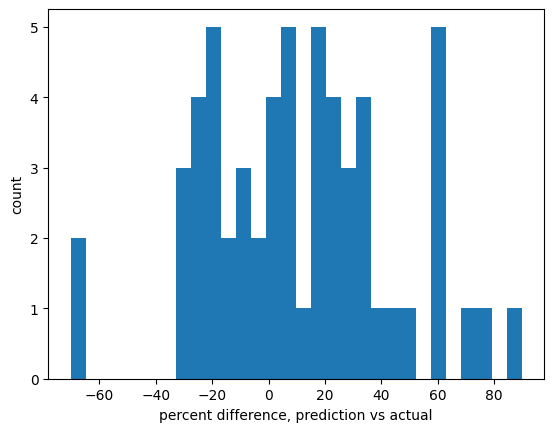

In [43]:
pleasantly_df_X_train=np.array(smell_df_shuffled.iloc[0:280,:]['fingerprint'].tolist())
pleasantly_df_y_train=np.array(smell_df_shuffled.iloc[0:280,:]['pleasantly'].tolist())
pleasantly_df_X_test=np.array(smell_df_shuffled.iloc[280:,:]['fingerprint'].tolist())
pleasantly_df_y_test=np.array(smell_df_shuffled.iloc[280:,:]['pleasantly'].tolist())




my_RandomForestRegressor_Pipeline=Pipeline(
    [
        ('my_StandardScaler',StandardScaler()),
        ('my_RandomForestRegressor',RandomForestRegressor())
    ]
)
my_RandomForestRegressor_parameters=[
    {
        'my_RandomForestRegressor__n_estimators':[1,3,5,10,20,40,100,200],
        'my_RandomForestRegressor__n_jobs':[4],
        'my_RandomForestRegressor__random_state':[1337]
    }
]





my_RandomForestRegressor_Gridsearch=GridSearchCV(
    my_RandomForestRegressor_Pipeline,
    my_RandomForestRegressor_parameters,
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

my_RandomForestRegressor_Gridsearch.fit(pleasantly_df_X_train,pleasantly_df_y_train)

my_RandomForestRegressor_Gridsearch_results=my_RandomForestRegressor_Gridsearch.cv_results_
for mean_score, params in zip(my_RandomForestRegressor_Gridsearch_results["mean_test_score"],my_RandomForestRegressor_Gridsearch_results["params"]):
    print(np.sqrt(-mean_score), params)

winner_RandomForestRegressor=my_RandomForestRegressor_Gridsearch.best_estimator_
plot_real_and_predict(winner_RandomForestRegressor,pleasantly_df_X_test,pleasantly_df_y_test)

## model training - chemically

17.21044382255323 {'my_RandomForestRegressor__n_estimators': 1, 'my_RandomForestRegressor__n_jobs': 4, 'my_RandomForestRegressor__random_state': 1337}
13.72985943079698 {'my_RandomForestRegressor__n_estimators': 3, 'my_RandomForestRegressor__n_jobs': 4, 'my_RandomForestRegressor__random_state': 1337}
13.161892965105329 {'my_RandomForestRegressor__n_estimators': 5, 'my_RandomForestRegressor__n_jobs': 4, 'my_RandomForestRegressor__random_state': 1337}
12.82471413490105 {'my_RandomForestRegressor__n_estimators': 10, 'my_RandomForestRegressor__n_jobs': 4, 'my_RandomForestRegressor__random_state': 1337}
12.777019775441548 {'my_RandomForestRegressor__n_estimators': 20, 'my_RandomForestRegressor__n_jobs': 4, 'my_RandomForestRegressor__random_state': 1337}
12.597665005815164 {'my_RandomForestRegressor__n_estimators': 40, 'my_RandomForestRegressor__n_jobs': 4, 'my_RandomForestRegressor__random_state': 1337}
12.57802467981637 {'my_RandomForestRegressor__n_estimators': 100, 'my_RandomForestRegres

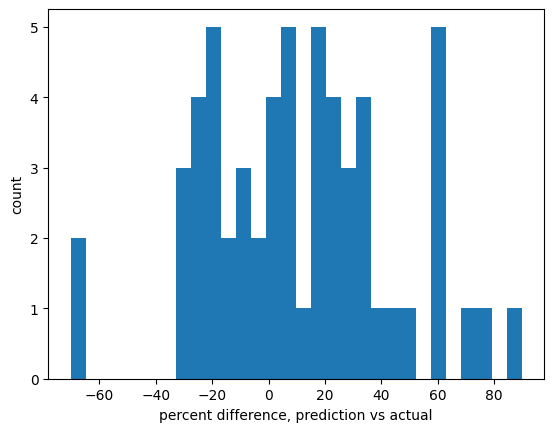

In [45]:
chemically_df_X_train=np.array(smell_df_shuffled.iloc[0:280,:]['fingerprint'].tolist())
chemically_df_y_train=np.array(smell_df_shuffled.iloc[0:280,:]['chemically'].tolist())
chemically_df_X_test=np.array(smell_df_shuffled.iloc[280:,:]['fingerprint'].tolist())
chemically_df_y_test=np.array(smell_df_shuffled.iloc[280:,:]['chemically'].tolist())




my_RandomForestRegressor_Pipeline=Pipeline(
    [
        ('my_StandardScaler',StandardScaler()),
        ('my_RandomForestRegressor',RandomForestRegressor())
    ]
)
my_RandomForestRegressor_parameters=[
    {
        'my_RandomForestRegressor__n_estimators':[1,3,5,10,20,40,100,200],
        'my_RandomForestRegressor__n_jobs':[4],
        'my_RandomForestRegressor__random_state':[1337]
    }
]





my_RandomForestRegressor_Gridsearch=GridSearchCV(
    my_RandomForestRegressor_Pipeline,
    my_RandomForestRegressor_parameters,
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

my_RandomForestRegressor_Gridsearch.fit(pleasantly_df_X_train,pleasantly_df_y_train)

my_RandomForestRegressor_Gridsearch_results=my_RandomForestRegressor_Gridsearch.cv_results_
for mean_score, params in zip(my_RandomForestRegressor_Gridsearch_results["mean_test_score"],my_RandomForestRegressor_Gridsearch_results["params"]):
    print(np.sqrt(-mean_score), params)

winner_RandomForestRegressor=my_RandomForestRegressor_Gridsearch.best_estimator_
plot_real_and_predict(winner_RandomForestRegressor,pleasantly_df_X_test,pleasantly_df_y_test)

Discussion: do we like these results? is this a good model? What is missing?
how coudl we guess if we generalize well?

# Generalization

## getting lots of nist gcms (volatile molecule) fingerprints

In [46]:
def create_nist_gc_df(directory_path):
    dfs=[pd.read_pickle(directory_path+file_name) for file_name in os.listdir(directory_path)]
    return pd.concat(dfs, axis='index',ignore_index=True)
        

In [47]:
lots_of_chemicals_df=create_nist_gc_df('../data_results/msp_pubchem_calls/')

In [48]:
lots_of_chemicals_df=lots_of_chemicals_df.rename({
    'CID':'cid',
    'SMILES':'smiles',
    'InChIKey':'inchikey',
    'CACTVS_Fingerprint':'fingerprint'
    },
    axis='columns'
)

In [49]:
lots_of_chemicals_df.fingerprint=lots_of_chemicals_df.fingerprint.apply(base_64_to_np_array)

In [50]:
smell_df_shuffled['flavor']='training_and_test'
lots_of_chemicals_df['flavor']='nist_gcms'
df_for_vis=pd.concat(
    [
        lots_of_chemicals_df[['fingerprint','flavor']],
        smell_df_shuffled[['fingerprint','flavor']],
        
    ],
    axis='index',
    ignore_index=True
)

        

In [51]:
df_for_vis

,fingerprint,flavor
0,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...",nist_gcms
1,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...",nist_gcms
2,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...",nist_gcms
3,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...",nist_gcms
4,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...",nist_gcms
...,...,...
85696,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...",training_and_test
85697,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...",training_and_test
85698,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, ...",training_and_test
85699,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...",training_and_test


discussion question

In [53]:
all_fingerprints=np.array(df_for_vis.fingerprint.tolist())
scaler = StandardScaler()
all_fingerprints_scaled=scaler.fit_transform(all_fingerprints)
pca = PCA()
all_fingerprints_pca_space= pca.fit_transform(all_fingerprints)



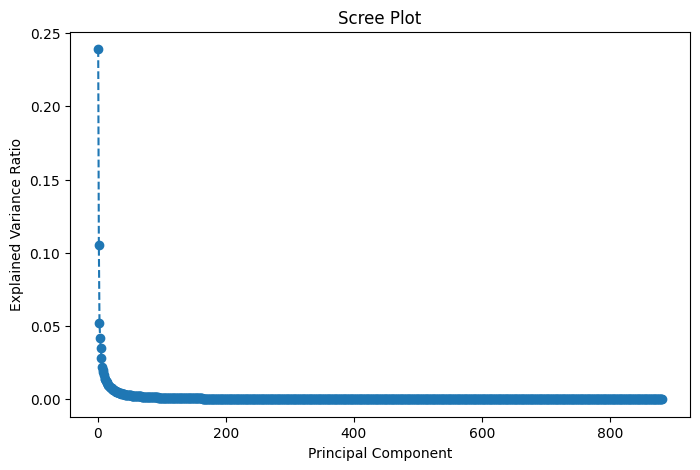

In [54]:
# Scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()



In [55]:
# Scatter plot of first two principal components
seaborn_df=pd.DataFrame.from_dict(
    {
        'component_0':all_fingerprints_pca_space[:, 0],
        'component_1':all_fingerprints_pca_space[:, 1],
        'color':df_for_vis.flavor.tolist()
    }
)

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

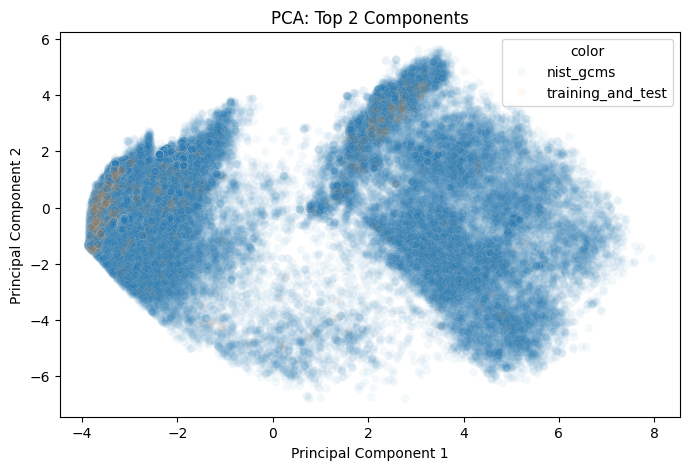

In [56]:


plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=seaborn_df,
    x='component_0',
    y='component_1',
    hue='color',
    alpha=0.05
)
# plt.scatter(all_fingerprints_pca_space[:, 0], all_fingerprints_pca_space[:, 1], c=df_for_vis.flavor, cmap='viridis', edgecolor='k', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Top 2 Components')
plt.colorbar(label='Target Label')
plt.show()

# Similarity

In [49]:
smell_df_shuffled

,cid,odor,pleasantly,chemically,smiles,inchikey,fingerprint,flavor
0,8077,Diethyl disulfide,20.653061,0.265306,CCSSCC,None,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...",training_and_test
1,7795,Isoamyl butyrate,51.822222,0.266667,CCCC(=O)OCCC(C)C,None,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...",training_and_test
2,14104,1-Methyl-3-methoxy-4-isopropylbenzene,42.790698,0.488372,CC1=CC(=C(C=C1)C(C)C)OC,None,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...",training_and_test
3,8857,ethyl acetate,43.705882,0.117647,CCOC(=O)C,None,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...",training_and_test
4,6057,L-Tyrosine,45.227273,0.318182,C1=CC(=CC=C1C[C@@H](C(=O)O)N)O,None,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, ...",training_and_test
...,...,...,...,...,...,...,...,...
333,12178,3-hexanol,36.000000,0.857143,CCCC(CC)O,None,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...",training_and_test
334,7695,Anisyl acetate,71.604651,0.325581,CC(=O)OCC1=CC=C(C=C1)OC,None,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...",training_and_test
335,7360,Tetrahydrofurfuryl alcohol,39.833333,0.366667,C1CC(OC1)CO,None,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...",training_and_test
336,7151,Methyl nicotinate,39.574468,0.595745,COC(=O)C1=CN=CC=C1,None,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, ...",training_and_test


In [58]:
smell_fingerprints=np.array(smell_df_shuffled.fingerprint.tolist())

In [59]:
smell_fingerprints

array([[1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0]], shape=(338, 881))

In [60]:
from sklearn.metrics import pairwise_distances
distance_matrix=pairwise_distances(
    smell_fingerprints,
    metric='jaccard'
)

/Users/pgleasonbremer/Library/Caches/pypoetry/virtualenvs/silly-smells-q7ZwBSwY-py3.11/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


/Users/pgleasonbremer/Library/Caches/pypoetry/virtualenvs/silly-smells-q7ZwBSwY-py3.11/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/pgleasonbremer/Library/Caches/pypoetry/virtualenvs/silly-smells-q7ZwBSwY-py3.11/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/pgleasonbremer/Library/Caches/pypoetry/virtualenvs/silly-smells-q7ZwBSwY-py3.11/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/pgleasonbremer/Library/Caches/pypoetry/virtualenvs/silly-smells-q7ZwBSwY-py3.11/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWar

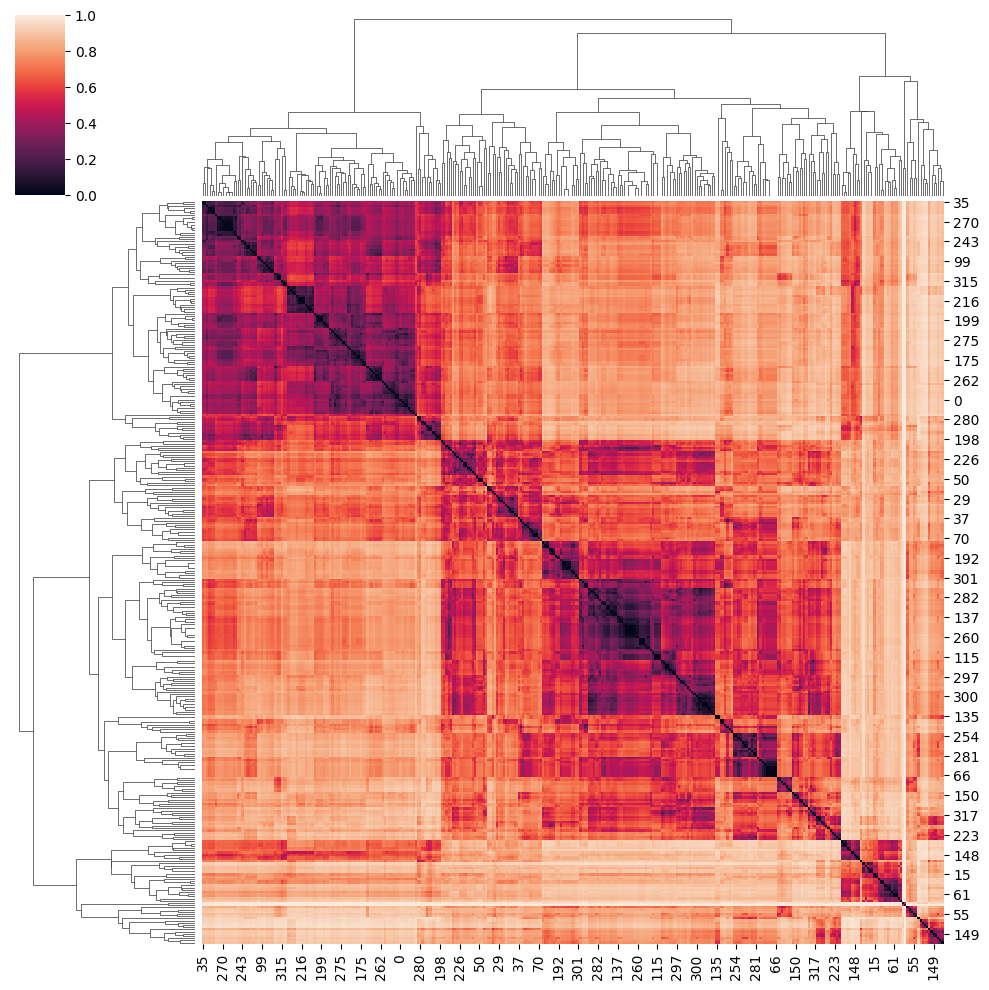

In [61]:
sns.clustermap(distance_matrix)